In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn import preprocessing
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv("prices-split-adjusted.csv", index_col=0)
data['adj close'] = data.close
data.drop(['close'], 1, inplace=True)
data = data[data.symbol == 'GOOG']
data.drop(['symbol'], 1, inplace=True)

In [3]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1, 1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1, 1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1, 1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1, 1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1, 1))
    return df

In [4]:
df = normalize_data(data)

In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]

    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]

In [6]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print("Compilation Time: ", time.time() - start)
    return model

In [7]:
window = 22  # assume 22 warking days per month
x_train, y_train, x_test, y_test = load_data(df, window)

In [8]:
model = build_model([5, window, 1])
model.fit(x_train, y_train, batch_size=512, epochs=90, validation_split=0.1, verbose=1)

('Compilation Time: ', 0.05748796463012695)
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 11s - loss: 0.1275 - acc: 7.1023e-04 - val_loss: 0.4972 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 8s - loss: 0.0560 - acc: 7.1023e-04 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 8s - loss: 0.0364 - acc: 7.1023e-04 - val_loss: 0.1360 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 8s - loss: 0.0152 - acc: 7.1023e-04 - val_loss: 0.1909 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 8s - loss: 0.0160 - acc: 7.1023e-04 - val_loss: 0.0927 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 8s - loss: 0.0055 - acc: 7.1023e-04 - val_loss: 0.0356 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================] - 8s - loss: 0.0080 - acc: 7.1023e-04 - val_loss: 0.0572

1408/1408 [==============================] - 12s - loss: 0.0011 - acc: 7.1023e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 62/90
1408/1408 [==============================] - 11s - loss: 0.0011 - acc: 7.1023e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 63/90
1408/1408 [==============================] - 9s - loss: 0.0011 - acc: 7.1023e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 64/90
1408/1408 [==============================] - 10s - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 65/90
1408/1408 [==============================] - 10s - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 66/90
1408/1408 [==============================] - 10s - loss: 9.8156e-04 - acc: 7.1023e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 67/90
1408/1408 [==============================] - 9s - loss: 9.5478e-04 - acc: 7.1023e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 68/90
1408/1408 [==============================] - 9s -

In [9]:
diff = []
ratio = []
p = model.predict(x_test)
print(p.shape)

(174, 1)


In [10]:
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append(y_test[u] / pr - 1)
    diff.append(abs(y_test[u] - pr))

In [11]:
def denormalize(data, normalized_value):
    data = data['adj close'].values.reshape(-1, 1)
    normalized_value = normalized_value.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(data)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [12]:
newp = denormalize(data, p)
newy_test = denormalize(data, y_test)

In [13]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [14]:
model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.00112 MSE (0.03 RMSE)
Test Score: 0.00924 MSE (0.10 RMSE)


(0.0011246581142321944, 0.0092369676407041221)

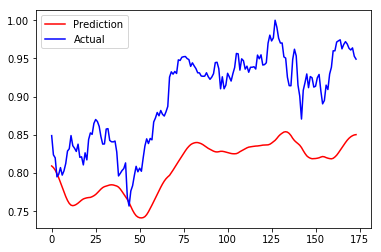

In [15]:
plt.plot(newp, color='red', label='Prediction')
plt.plot(newy_test, color='blue', label='Actual')
plt.legend(loc='best')
plt.show()